# 7-4 记录

## Import

In [1]:
#pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


## Data Prep

In [2]:
data = scipy.io.loadmat('Data/burgers_shock_mu_01_pi.mat')  	# Load data from file
x = data['x']                                   # 256 points between -1 and 1 [256x1]
t = data['t']                                   # 100 time points between 0 and 1 [100x1] 
usol = data['usol']                             # solution of 256x100 grid points

X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple

## *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

In [3]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u = usol.flatten('F')[:,None] 


## *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [4]:
def trainingdata(N_u,N_f):

    '''Boundary Conditions'''

    #Initial Condition -1 =< x =<1 and t = 0  
    leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
    leftedge_u = usol[:,0][:,None]

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
    bottomedge_u = usol[-1,:][:,None]

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
    topedge_u = usol[0,:][:,None]

    all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
    all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train 


## Plot

In [5]:
def solutionplot(u_pred,X_u_train,u_train):
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.25s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75s$', fontsize = 10)
    
    #plt.savefig('./Results/Burgers.png',dpi = 500)   

## MyPinn

### Model Define

In [6]:
def createModel(layer,Model):
    if len(layer) < 2:
        print("层数小于2！, 无法构建神经网络")
        return 
    model = Model(name = "PINN")
    model.add(keras.Input(shape=(layer[0],),dtype=tf.float64))
    for i in range(1,len(layer)-1):
        model.add(layers.Dense(layer[i],dtype=tf.float64, activation='tanh'))
    model.add(layers.Dense(layer[-1], dtype=tf.float64, name="outputs"))    
    return model

In [7]:
class MyPinn(keras.Sequential): ## 正在编写
    def __init__(self,name = None):
        
      super(MyPinn, self).__init__(name=name)
      self.nu = tf.constant(0.01/np.pi,dtype=tf.float64)
    
    @tf.function
    def loss_U(self,X_u_train,u_train):
      u_pred = self(X_u_train)
      loss_u = tf.reduce_mean(tf.square(u_train - u_pred))
      return loss_u
    
    
    @tf.function
    def loss_PDE(self,X_f_train):
      
      x = X_f_train[:,0:1]
      t = X_f_train[:,1:2]
      with tf.GradientTape(persistent=True) as tape:
          tape.watch([x,t])
          X = tf.stack([x[:,0],t[:,0]],axis=1)
          u = self(X)  
          u_x = tape.gradient(u,x)         
      #tf.print(u_x)    
      u_t = tape.gradient(u, t)     
      u_xx = tape.gradient(u_x, x)
      
      del tape
      
      f = u_t + (self(X))*(u_x) - (self.nu)*u_xx

      loss_f = tf.reduce_mean(tf.square(f))

      return loss_f
    
    @tf.function
    def loss_Total(self,X_u_train,u_train,X_f_train):
      loss_u = self.loss_U(X_u_train,u_train)
      loss_f = self.loss_PDE(X_f_train)
      
      loss_total = loss_u + loss_f
      
      return loss_total
    
    @tf.function
    def train_step(self,X_u_train,u_train,X_f_train):
      with tf.GradientTape(persistent=True) as tape:
          loss_total = self.loss_Total(X_u_train,u_train,X_f_train)
                  
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss_total, trainable_vars)
      #tf.print(gradients)
      del tape
      
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))
      return loss_total
    
    @tf.function
    def train_model(self, X_u_train,u_train,X_f_train, epochs=100):
      for epoch in tf.range(1,epochs+1):
          loss_total = self.train_step(X_u_train,u_train,X_f_train)
          if epoch % 50 == 0:                
              tf.print(
                  "Training loss (for per 10 epoches) at epoch ",epoch,":",loss_total
              )

### function_factory

In [8]:
def function_factory(model, loss, X_u_train,u_train,X_f_train):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a loss function in model
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_Total = loss(X_u_train,u_train,X_f_train)

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_Total, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        if (f.iter % 50 == 0) :
          tf.print("Iter:", f.iter, "loss:", loss_Total)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_Total], Tout=[])

        return loss_Total, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

## Training and Testing

In [9]:
N_u = 100 #Total number of data points for 'u'
N_f = 1000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)


layerss = [2,20,20,20,20,20,20,20,20,1] #8 hidden layer


m1= createModel(layerss,MyPinn)
m1.compile(keras.optimizers.Adam())
m1.summary()

Model: "PINN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420       
                                                                 
 dense_6 (Dense)             (None, 20)                420    

In [ ]:
g = tf.Variable(X_f_train,dtype=tf.float64)

x = g[:,0:1]
t = g[:,1:2]
g = tf.stack([x[:,0], t[:,0]], axis=1)


xx = g[:,0]
tt = g[:,1]
gg = tf.stack([xx,tt],axis=-1)

print(gg==g)

In [10]:
m1.train_model(X_u_train,u_train,X_f_train,epochs=200) ## Adam优化阶段

Training loss (for per 10 epoches) at epoch  50 : 0.18890239727047953
Training loss (for per 10 epoches) at epoch  100 : 0.14220972594289302
Training loss (for per 10 epoches) at epoch  150 : 0.11135544468040587
Training loss (for per 10 epoches) at epoch  200 : 0.091774675034514447


In [11]:

func = function_factory(m1, m1.loss_Total, X_u_train,u_train,X_f_train)
init_params = tf.dynamic_stitch(func.idx, m1.trainable_variables)

## L-BFGS 优化阶段
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=func,
    initial_position=init_params, 
    num_correction_pairs=100, 
    x_tolerance = 0,
    f_relative_tolerance = 0,
    parallel_iterations = 1,
    max_line_search_iterations = 100,
    max_iterations=100) 

Iter: 50 loss: 0.086896559047310071
Iter: 100 loss: 0.078571429370618756
Iter: 150 loss: 0.0664171194839861
Iter: 200 loss: 0.055029627523589343
Iter: 250 loss: 0.063562270622008171


Test Error: 0.48325


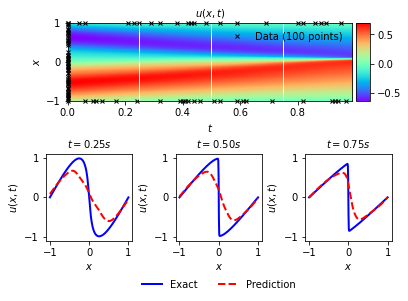

In [13]:
u_pred = m1(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

u_pred = np.reshape(u_pred,(256,100),order='F')                        # Fortran Style ,stacked column wise!

''' Solution Plot '''
solutionplot(u_pred,X_u_train,u_train)